<a href="https://colab.research.google.com/github/gloriankosi/notebooks/blob/main/heart_disease_uci.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [458]:
# https://www.kaggle.com/ronitf/heart-disease-uci
from google.colab import drive
drive.mount('/content/drive/')
% cd "/content/drive/My Drive/data-science"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data-science


In [459]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz


# age
# sex
# chest pain type (4 values)
# resting blood pressure
# serum cholestoral in mg/dl
# fasting blood sugar > 120 mg/dl
# resting electrocardiographic results (values 0,1,2)
# maximum heart rate achieved
# exercise induced angina
# oldpeak = ST depression induced by exercise relative to rest
# the slope of the peak exercise ST segment
# number of major vessels (0-3) colored by flourosopy
# thal: 3 = normal; 6 = fixed defect; 7 = reversable defect


### A look at the data

In [460]:
data = pd.read_csv("heart.csv")
data.head(20)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


### Correlation Matrix

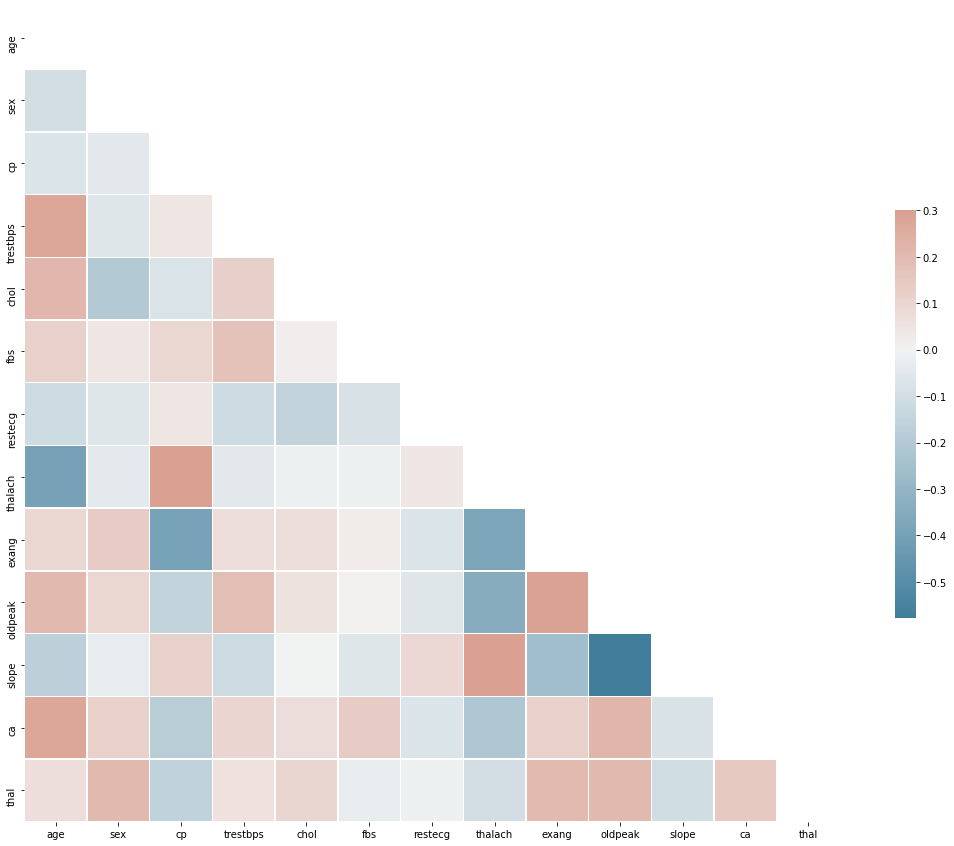

In [461]:
corr = data.drop("target" , 1).corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(20, 15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
_=sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [462]:
X_train, X_test, y_train, y_test = train_test_split(data.drop("target" , 1) , data.target, test_size=.2)

## Comparisons between different models

### *Using a Decision Tree Model*

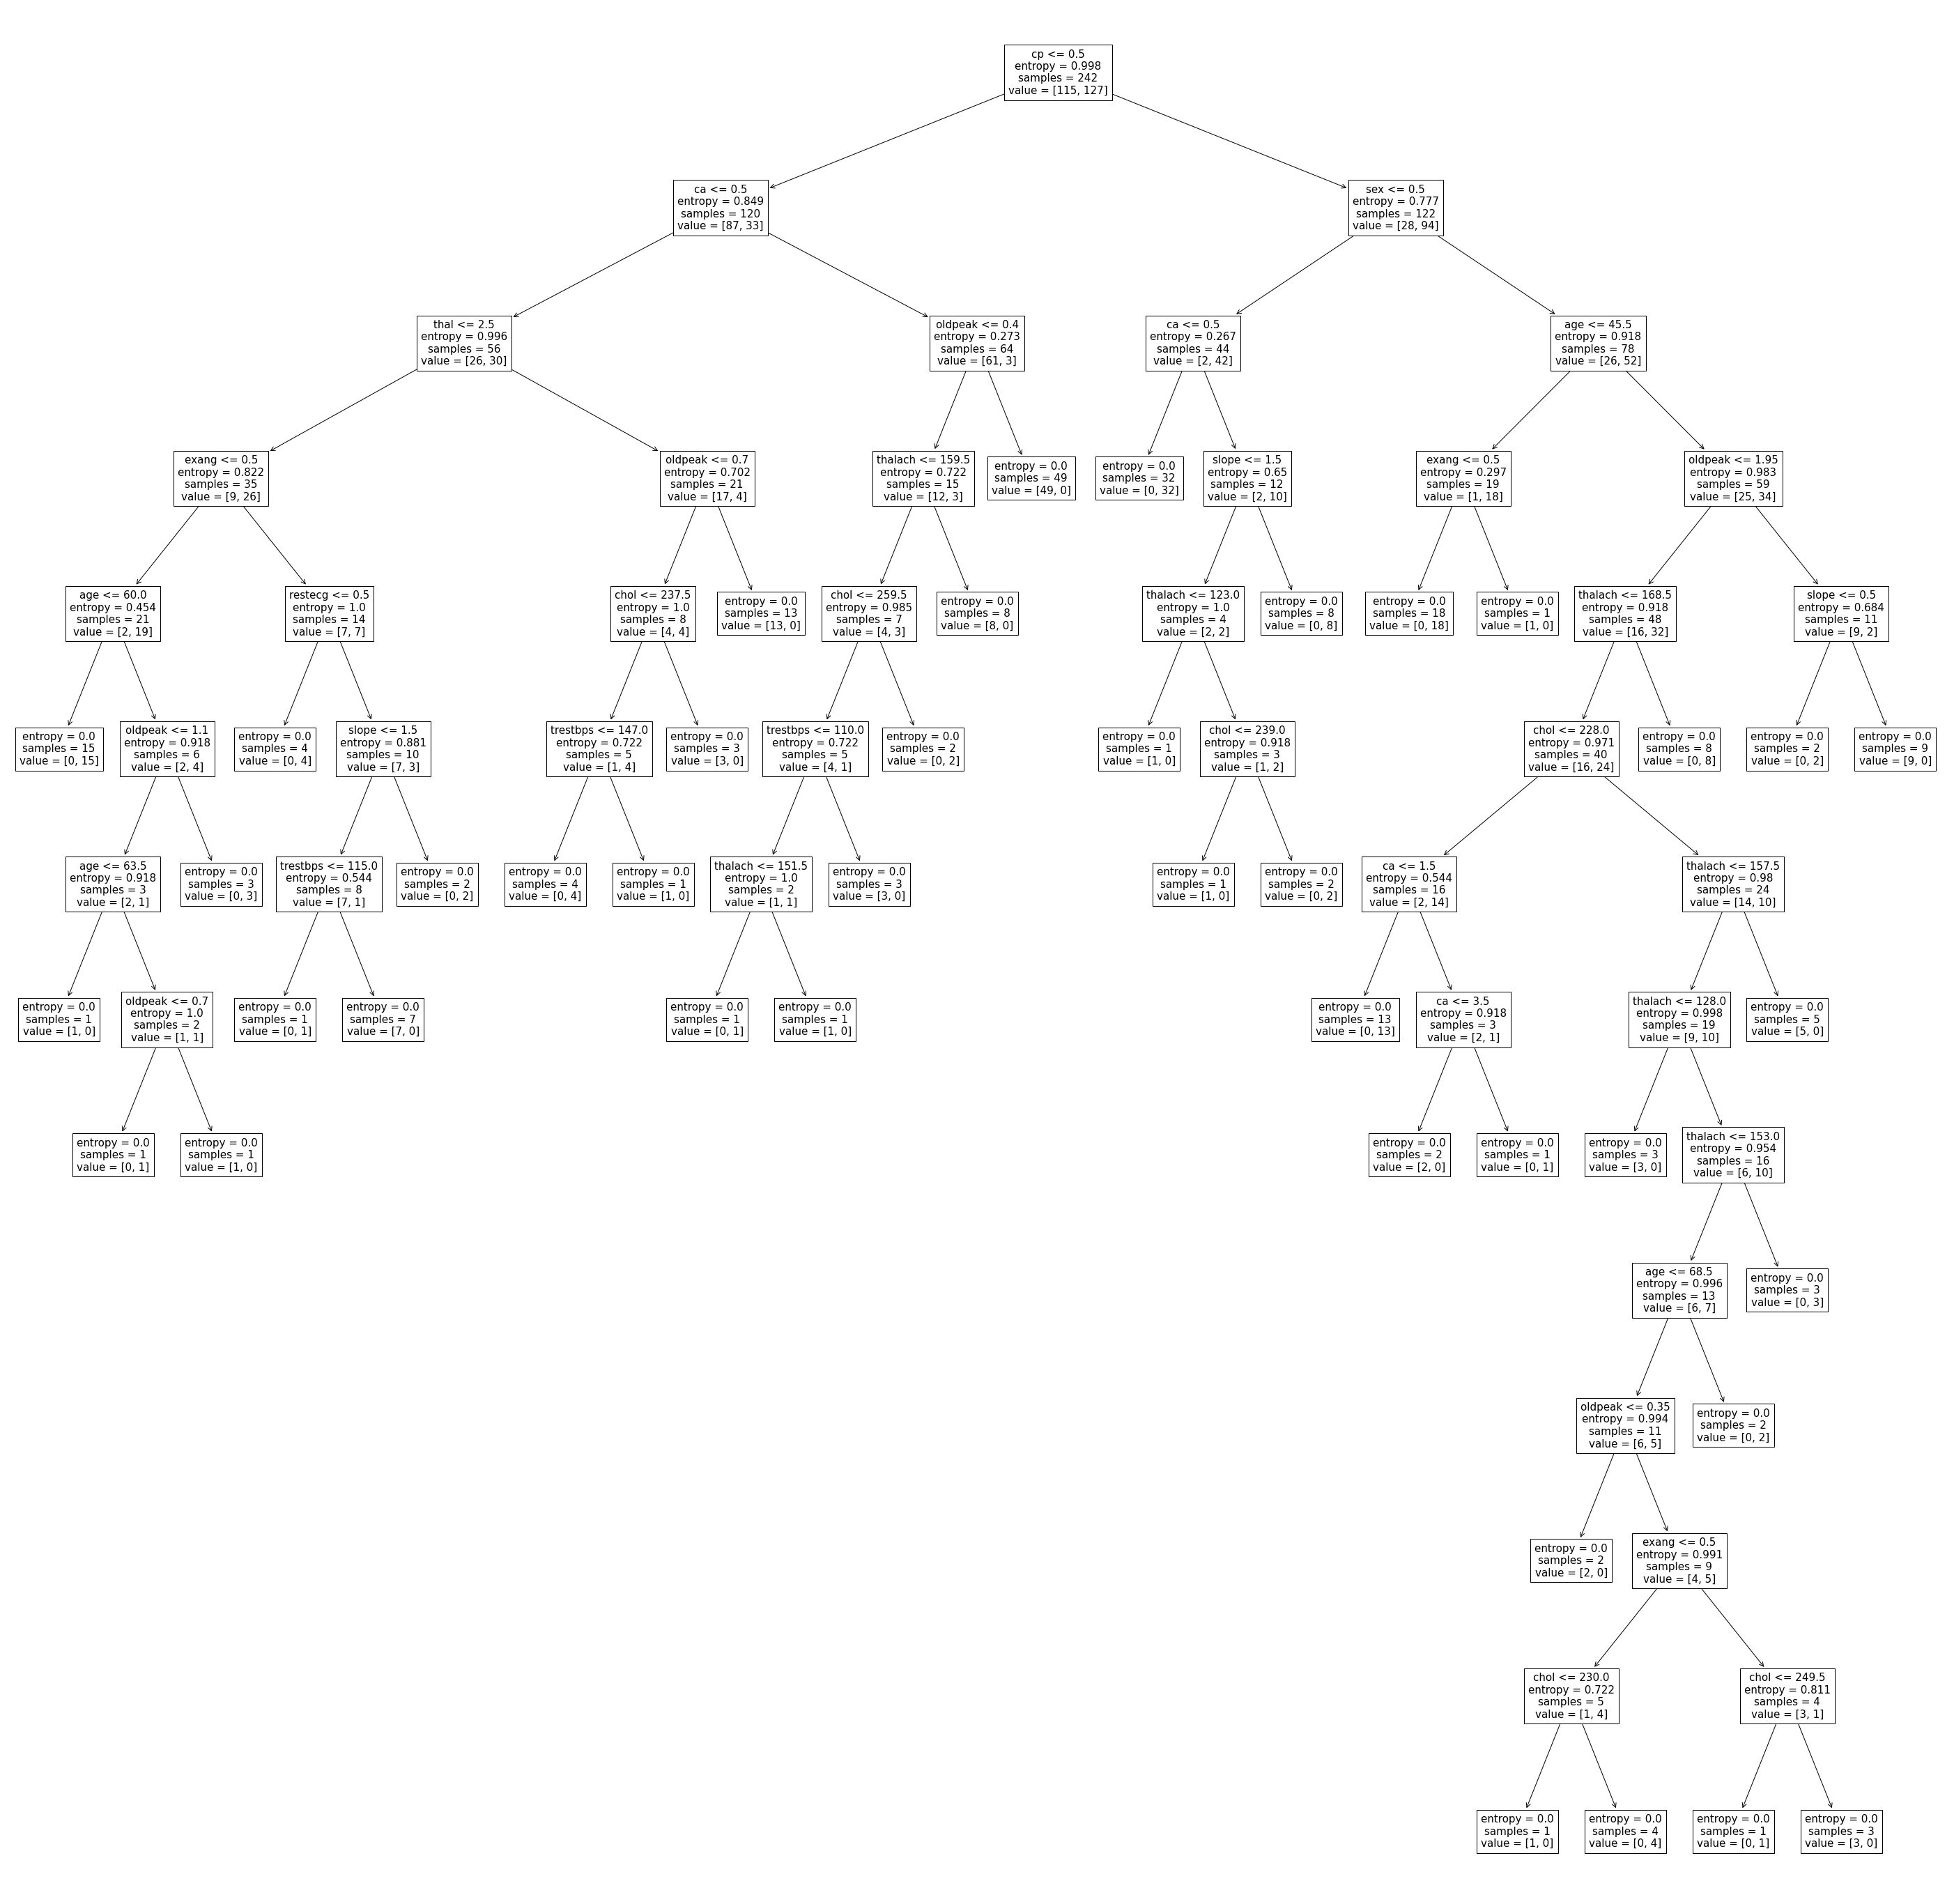

In [463]:
plt.figure(figsize=(50,50))
model = DecisionTreeClassifier(criterion='entropy')
_=model.fit(X_train, y_train)
_=tree.plot_tree(model , feature_names=[x for x in data.columns])

NOTE: Root node is 'cp' (chest pain), which has the highest entropy and makes intuitive sense.

#### Cross Validation

In [464]:
scores = cross_val_score(model , X_test,y_test , cv=10 , scoring="accuracy") # cv=10
print(scores.mean())
print(scores.std())
print('\n')
scores = cross_val_score(model , X_test,y_test , cv=5 , scoring="accuracy")# cv=5
print(scores.mean())
print(scores.std())

0.7690476190476191
0.13470804914110132


0.7538461538461538
0.09161061582025562


Cross Validation with 10 splits tends to yield a higher standard deviation and higher accuracy mean as opposed to 5 splits. 

#### Confusion Matrix

[[14  9]
 [ 6 32]]


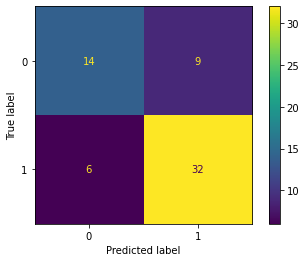

In [465]:
y_pred_single_decision_tree=model.predict(X_test)
cm = confusion_matrix(y_test , y_pred_single_decision_tree)
print(cm)
_=plot_confusion_matrix(model, X_test , y_test)

#### Confusion Matrix Reports

In [466]:
print(classification_report(y_test, y_pred_single_decision_tree))

              precision    recall  f1-score   support

           0       0.70      0.61      0.65        23
           1       0.78      0.84      0.81        38

    accuracy                           0.75        61
   macro avg       0.74      0.73      0.73        61
weighted avg       0.75      0.75      0.75        61



### *Using a Random Forest Model*

In [467]:
model = RandomForestClassifier(criterion='entropy' , n_estimators=500)
_=model.fit(X_train, y_train)

#### Cross Validation

In [468]:
scores = cross_val_score(model , X_test,y_test , cv=10 , scoring="accuracy") # cv=10
print(scores.mean())
print(scores.std())
print('\n')
scores = cross_val_score(model , X_test,y_test , cv=5 , scoring="accuracy")# cv=5
print(scores.mean())
print(scores.std())

0.8333333333333333
0.14907119849998599


0.85
0.097182531580755


Random Forest consistently performs better on 5 splits for both accuracy mean and standard deviation. 

#### Confusion Matrix

[[16  7]
 [ 2 36]]


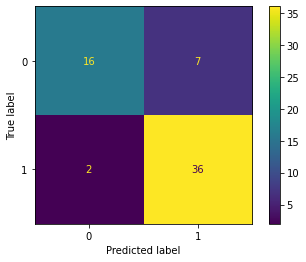

In [469]:
y_pred_random_forest_tree=model.predict(X_test)
cm = confusion_matrix(y_test , y_pred_random_forest_tree)
print(cm)
_=plot_confusion_matrix(model, X_test , y_test)

#### Confusion Matrix

In [470]:
# Precision = TruePositives / (TruePositives + FalsePositives)
# Recall = TruePositives / (TruePositives + FalseNegatives)
print(classification_report(y_test, y_pred_random_forest_tree))

              precision    recall  f1-score   support

           0       0.89      0.70      0.78        23
           1       0.84      0.95      0.89        38

    accuracy                           0.85        61
   macro avg       0.86      0.82      0.83        61
weighted avg       0.86      0.85      0.85        61



### Using a Logistic Regression Model

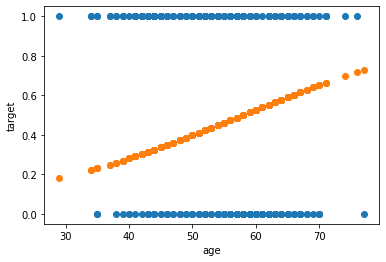

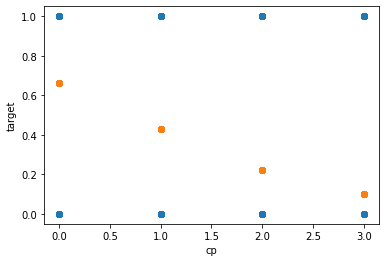

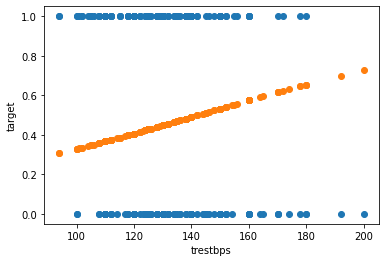

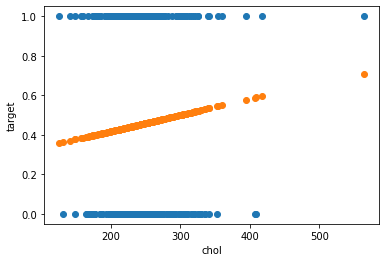

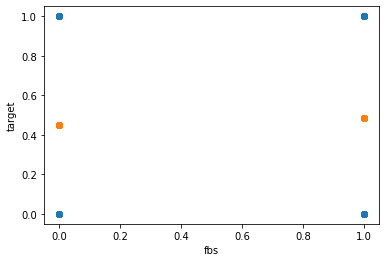

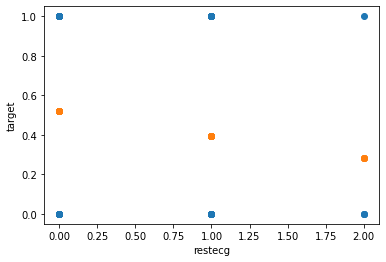

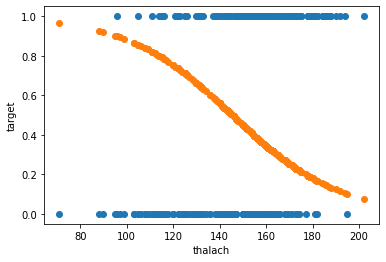

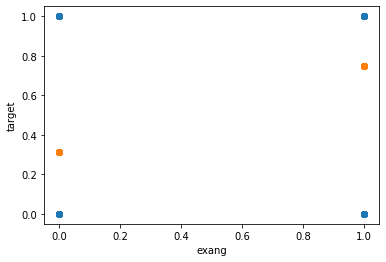

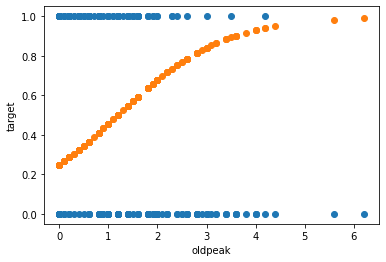

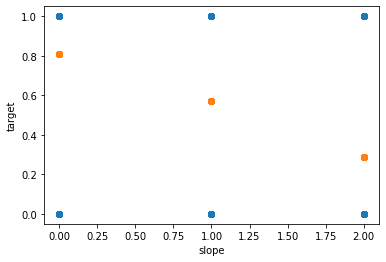

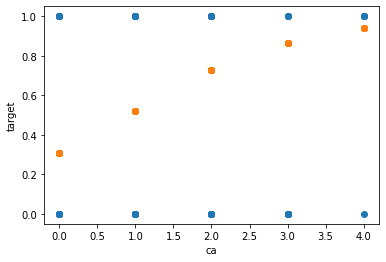

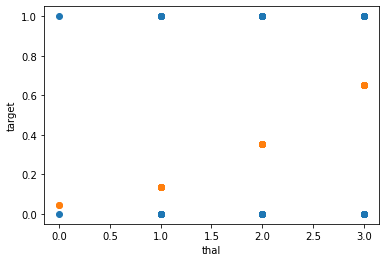

In [471]:
for col in data.columns.drop(['target' , 'sex'] , 1):
  X=data[col].values.reshape(-1,1)
  model=LogisticRegression(max_iter=1000).fit(X, np.ravel(Y.astype(int)))
  x_pred_proba = model.predict_proba(X)
  Y=data['target'].values.reshape(-1,1)
  plt.xlabel(col)
  plt.ylabel('target')
  plt.scatter(X , Y)
  plt.scatter(X , x_pred_proba[:,0])
  plt.show()